In [153]:
import sys
import pandas as pd
import numpy as np
from tqdm import tqdm
import random
import geopandas as gpd
import contextily as cx
import os
os.environ['PROJ_LIB'] = r'/Users/chenyangkang/miniforge3/share/proj'

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from sklearn.metrics import recall_score, precision_score, average_precision_score, roc_auc_score,\
                            cohen_kappa_score,f1_score,precision_recall_curve,PrecisionRecallDisplay

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from quadtree import *
from filter_data_script import *
from AdaSTEM_classifier_utiles import *
from get_variable_dict import *

In [4]:
#### checklist data (location, time, environmental variables...)
checklist_feature = pickle.load(open('American_snapshot_10_10_500_each_grid.pkl','rb'))
checklist_feature = filter_data(checklist_feature,2018)

In [5]:
##### get variable list
variable_dict = get_variable_dict()
variable_dict.keys()

dict_keys(['sampling_variables', 'time_variables', 'landscape_variables', 'climate_variables', 'land_use_variables'])

In [6]:
##### overall there are 105 predictors
all_variable_names = []
for i in variable_dict.values():
    all_variable_names.extend(i)
len(all_variable_names)


105

In [161]:
sp_list = [i.split('_2018')[0] for i in os.listdir(f'./sp_count/') if '2018' in i]

In [162]:
sp_list

['Blythapostrophes_Reed_Warbler',
 'White_Wagtail',
 'Osprey',
 'Chipping_Sparrow',
 'Black-capped_Chickadee',
 'Black_Vulture',
 'Burrowing_Owl',
 'Blue_Jay',
 'Cedar_Waxwing',
 'Collared_Forest-Falcon',
 'Red-winged_Blackbird',
 'Carolina_Chickadee',
 'Eastern_Phoebe',
 'Ring-billed_Gull',
 'Mississippi_Kite',
 'Dark-eyed_Junco',
 'Broad-winged_Hawk',
 'American_Crow',
 'Harrisapostrophes_Hawk',
 'Mourning_Dove',
 'Oriental_Honey-buzzard',
 'Gray_Hawk',
 'Snowy_Owl',
 'Common_Sandpiper',
 'Yellow-rumped_Warbler',
 'Long-eared_Owl',
 'Prairie_Falcon',
 'Common_Raven',
 'Canada_Goose',
 'Elf_Owl',
 'Northern_Saw-whet_Owl',
 'Mallard',
 'Whiskered_Screech-Owl',
 'Northern_Pintail',
 'Golden_Eagle',
 'Red-bellied_Woodpecker',
 'Zone-tailed_Hawk',
 'Pin-tailed_Snipe',
 'White-crowned_Sparrow',
 'Collared_Pratincole',
 'American_Coot',
 'Carolina_Wren',
 'Peregrine_Falcon',
 'Bald_Eagle',
 'Herring_Gull',
 'Green_Sandpiper',
 'Ferruginous_Hawk',
 'Barred_Owl',
 'Tickellapostrophes_Leaf_War

Blythapostrophes_Reed_Warbler XXX
White_Wagtail XXX
Osprey XXX
Chipping_Sparrow XXX
Black-capped_Chickadee YYY
Black_Vulture YYY
Burrowing_Owl XXX
Blue_Jay YYY
Cedar_Waxwing XXX
Collared_Forest-Falcon XXX
Red-winged_Blackbird YYY
Carolina_Chickadee XXX
Eastern_Phoebe XXX
Ring-billed_Gull XXX
Mississippi_Kite XXX
Dark-eyed_Junco YYY
Broad-winged_Hawk XXX
American_Crow YYY
Harrisapostrophes_Hawk XXX
Mourning_Dove YYY
Oriental_Honey-buzzard XXX
Gray_Hawk XXX
Snowy_Owl XXX
Common_Sandpiper XXX
Yellow-rumped_Warbler YYY
Long-eared_Owl XXX
Prairie_Falcon XXX
Common_Raven YYY
Canada_Goose YYY
Elf_Owl XXX
Northern_Saw-whet_Owl XXX
Mallard YYY
Whiskered_Screech-Owl XXX
Northern_Pintail XXX
Golden_Eagle XXX
Red-bellied_Woodpecker XXX
Zone-tailed_Hawk XXX
Pin-tailed_Snipe XXX
White-crowned_Sparrow XXX
Collared_Pratincole XXX
American_Coot XXX
Carolina_Wren XXX
Peregrine_Falcon XXX
Bald_Eagle XXX
Herring_Gull XXX
Green_Sandpiper XXX
Ferruginous_Hawk XXX
Barred_Owl XXX
Tickellapostrophes_Leaf_Warbl

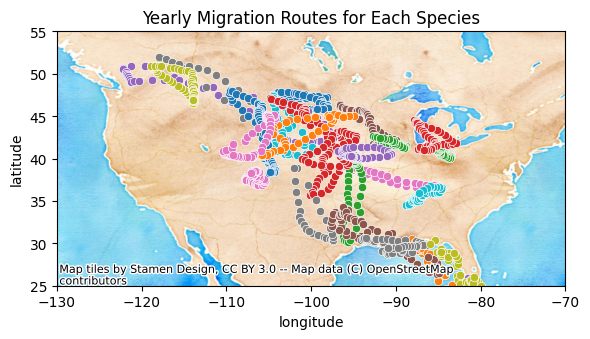

In [177]:
plt.figure(figsize=(6,10))

sps_used = 0
for sp in sp_list:
    
    #### species count data
    sp_data = pickle.load(open(f'./sp_count/{sp}_2018.pkl','rb'))
    #### merge them
    data = pd.merge(checklist_feature, sp_data, on='sampling_event_identifier', how='left')
    data['count'] = data['count'].fillna(0)
    data['occ'] = np.where(data['count']>0,1,0)

    #### calc geo cent
    data = data[['longitude','latitude','doy','occ','week']]
    data = data[data['occ']==1]
    if len(data)<40000:
        print(sp,'XXX')
        continue

    print(sp,'YYY')
    sps_used+=1
    geo_cent = data.groupby('week').median().reset_index(drop=False).set_index('week')

    #### geo moving average
    geo_cent = geo_cent.reset_index(drop=False)

    geo_cent = pd.concat([
        geo_cent.iloc[-10:,:],
        geo_cent,
        geo_cent.iloc[:10,:]
    ],axis=0)

    geo_cent = geo_cent.rolling(10,center=True).mean().dropna().iloc[5:-6,:]
    geo_cent['week'] = geo_cent.index+1

    #### plot
    a = sns.scatterplot(
        x=geo_cent.longitude,
        y=geo_cent.latitude,
        # hue=geo_cent.week,
        label=sp
        # cmap='coolwarm'
    )

print(f'{sps_used} sps used in total')

plt.xlim(-130,-70) #plt.xlim(-160,-20)
plt.ylim(25,55) #plt.ylim(-70,85)
cx.add_basemap(a,crs='EPSG:4326',source=cx.providers.Stamen.Watercolor)

plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Yearly Migration Routes for Each Species')
# plt.legend(bbox_to_anchor=(2,1))
# plt.legend(None)
plt.tight_layout()
plt.gca().legend().remove()

plt.savefig('Migration_routes_NA.png',dpi=500)

plt.show()



<Figure size 640x480 with 0 Axes>

In [163]:
data

,longitude,latitude,doy,occ,week
0,-72.888892,-49.081172,43,1,7
4,-65.590439,-44.913763,31,1,5
15,-83.772179,9.827732,241,1,35
25,-71.650398,-33.344305,264,1,38
30,-103.712075,19.455920,57,1,9
...,...,...,...,...,...
487245,-84.213849,10.016440,2,1,1
487256,-82.959038,8.826605,263,1,38
487261,-71.713448,-39.131411,108,1,16
487268,-75.437864,5.073222,175,1,25


<Axes: xlabel='longitude', ylabel='latitude'>

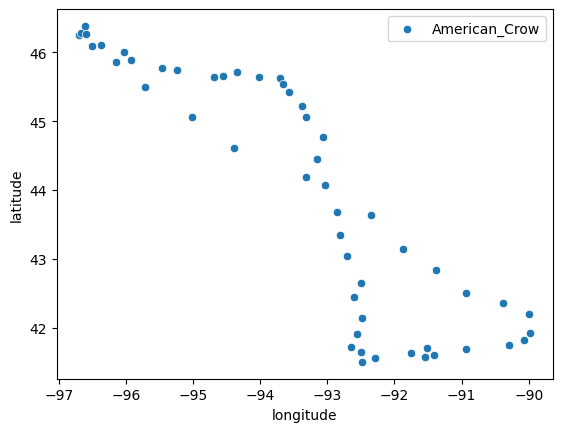

<Axes: xlabel='longitude', ylabel='latitude'>

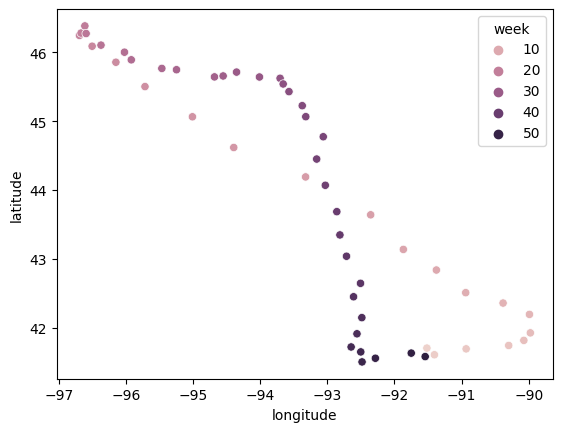

In [24]:
geo_cent


,doy,longitude,latitude,occ
0,1,-92.948003,41.291406,1.0
1,2,-92.346089,40.881681,1.0
2,3,-88.651439,41.123784,1.0
3,4,-94.023713,42.279671,1.0
4,5,-95.704029,42.044885,1.0
...,...,...,...,...
360,361,-86.430685,40.798334,1.0
361,362,-97.510800,40.518863,1.0
362,363,-90.098333,40.541105,1.0
363,364,-92.583810,40.654061,1.0
